# Stock Price Forecasting with Long Short-Term Memory Network and Feature Extraction by Autoencoders

## Libraries

In [71]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modeling
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.regularizers import l2

# Graphics
import matplotlib.pyplot as plt

## Load Data

In [6]:
dataset = pd.read_csv('data/dataset.csv')
dataset

,Datetime,open,high,low,close,HT_DCPERIOD,HT_DCPHASE,ADD,DIV,MAX,...,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ATR,NATR,TRANGE,D+0 ALTA,D+1 ALTA
0,2023-12-04 11:29:00-03:00,127562.742188,127562.742188,127554.031250,127554.031250,21.191403,55.019323,255116.773438,1.000068,127578.218750,...,127425.843527,9.326614,23.767622,127556.416123,564.899843,27.622438,0.021655,14.585938,0,1.0
1,2023-12-04 11:30:00-03:00,127587.453125,127613.523438,127587.453125,127613.523438,21.119264,68.492625,255200.976562,1.000204,127613.523438,...,127436.214955,10.084633,36.381383,127577.399811,1323.605030,29.898848,0.023429,59.492188,1,1.0
2,2023-12-04 11:31:00-03:00,127577.640625,127591.148438,127577.640625,127591.148438,21.330968,81.644226,255168.789062,1.000106,127613.523438,...,127443.225000,10.650910,29.961326,127592.337740,897.681068,30.326274,0.023768,35.882812,1,1.0
3,2023-12-04 11:32:00-03:00,127615.359375,127617.046875,127615.359375,127617.046875,22.017217,94.351672,255232.406250,1.000013,127617.046875,...,127447.169866,11.804825,28.964385,127612.437414,838.935619,30.010000,0.023516,25.898438,1,0.0
4,2023-12-04 11:33:00-03:00,127698.460938,127698.460938,127671.132812,127671.132812,23.249552,105.744247,255369.593750,1.000214,127671.132812,...,127444.277232,14.403692,38.171279,127645.928915,1457.046568,33.681719,0.026382,81.414062,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,2023-12-08 16:54:00-03:00,127066.687500,127169.757812,127066.687500,127169.757812,20.730092,168.494730,254236.445312,1.000811,127169.757812,...,126566.146652,42.908499,88.303873,127166.865642,7797.573917,51.486649,0.040487,103.070312,1,0.0
2005,2023-12-08 16:55:00-03:00,127180.796875,127180.796875,127145.421875,127145.421875,21.363536,171.420071,254326.218750,1.000278,127169.757812,...,126598.784375,43.763685,50.753929,127211.475962,2575.961313,50.335817,0.039589,35.375000,0,1.0
2006,2023-12-08 16:56:00-03:00,127111.023438,127117.781250,127111.023438,127117.781250,21.294634,175.181402,254228.804688,1.000053,127169.757812,...,126650.460045,41.409306,40.641591,127230.190333,1651.738884,49.197433,0.038702,34.398438,1,0.0
2007,2023-12-08 16:57:00-03:00,127118.976562,127118.976562,127101.492188,127101.492188,20.787720,179.762302,254220.468750,1.000138,127169.757812,...,126696.506027,38.894334,27.522654,127241.026700,757.496510,46.932215,0.036925,17.484375,0,1.0


## Data Preparation

### D+5

In [7]:
# dataset.loc[:,['D+5 ALTA']] = dataset['D+0 ALTA'].shift(-5)
# dataset = dataset.dropna()
# dataset

### Data segregation

In [8]:
dataset['date'] = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(dataset['Datetime'])]

In [9]:
training_set = pd.DataFrame()
for data in ['2023-12-04','2023-12-05','2023-12-06']:
    aux = dataset.query('date == @data')
    training_set = pd.concat([training_set, aux], axis=0)
val_set = dataset.query('date == "2023-12-07"')
test_set = dataset.query('date == "2023-12-08"')

In [10]:
# Traning set
X_train = training_set.drop(['Datetime', 'date', 'D+1 ALTA'],axis=1)
y_train = training_set['D+1 ALTA']
# Validation set
X_val = val_set.drop(['Datetime', 'date', 'D+1 ALTA'],axis=1)
y_val = val_set['D+1 ALTA']
# Validation set
X_test = test_set.drop(['Datetime', 'date', 'D+1 ALTA'],axis=1)
y_test = test_set['D+1 ALTA']

### Feature scaling

In [11]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val],axis=0))
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Modeling

### Feature Extraction with Autoencoders

In [12]:
def autoencoder(X_train, X_val, epochs, verbose):
    # Definir a arquitetura do autoencoder
    input_dim = X_train.shape[1]
    encoding_dim = 24
    
    input_layer = Input(shape=(input_dim,))
    encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
    decoder_layer = Dense(input_dim, activation='relu')(encoder_layer)
    
    autoencoder_model = Model(inputs=input_layer, outputs=decoder_layer)
    
    # Criar um modelo separado para o encoder
    encoder_model = Model(inputs=input_layer, outputs=encoder_layer)

    # Compilação do modelo
    autoencoder_model.compile(optimizer='adam', loss='mse', metrics=['MAE'])

    # Resumo da arquitetura da rede
    autoencoder_model.summary()

    history = autoencoder_model.fit(X_train, X_train, epochs=epochs, shuffle=True,
                        validation_data=(X_val, X_val), verbose=verbose)

    return autoencoder_model, encoder_model, history

In [13]:
autoencoder_model, encoder_nodel, history = autoencoder(X_train_scaled, X_val_scaled, epochs=150, verbose=0)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 76)]              0         
                                                                 
 dense (Dense)               (None, 24)                1848      
                                                                 
 dense_1 (Dense)             (None, 76)                1900      
                                                                 
Total params: 3,748
Trainable params: 3,748
Non-trainable params: 0
_________________________________________________________________


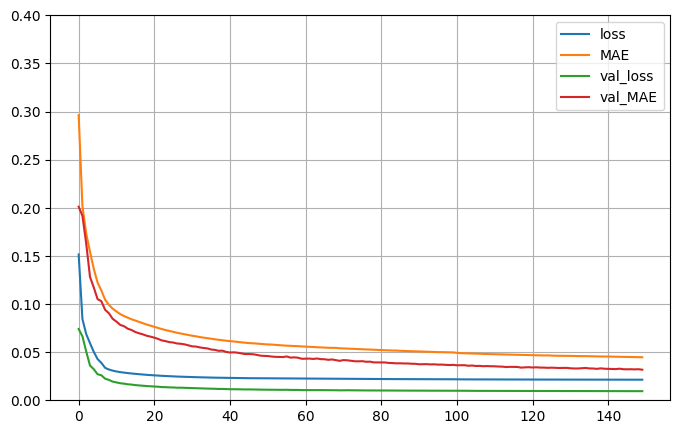

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.4) # set the vertical range to [0-1]
plt.show()

In [15]:
loss, mae = autoencoder_model.evaluate(X_test_scaled, X_test_scaled, verbose=0)
#print(f'Loss \t = {loss}')
print(f'MAE = {mae}')

MAE = 0.04637964442372322


In [32]:
X_train_encoded = encoder_nodel.predict(X_train_scaled)
X_val_encoded = encoder_nodel.predict(X_val_scaled)
X_test_encoded = encoder_nodel.predict(X_test_scaled)

print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_val_encoded shape:{X_val_encoded.shape}")
print(f"X_test_encoded shape:{X_test_encoded.shape} ")

14/14 [==============================] - 0s 1ms/step
X_train_encoded shape: (1171, 24)
X_val_encoded shape:(420, 24)
X_test_encoded shape:(418, 24) 


### Stock Price Forecasting with LSTM

#### Reshape data

In [26]:
# Função para criar sequências de passos temporais
def create_sequences(data, target, timesteps):
    X = []
    y = []
    sequences = []
    for i in range(len(data) - timesteps + 1):
        # find the end of this pattern
        end_ix = i + timesteps
            # check if we are beyond the dataset
        if end_ix > len(data):
            break
        seq_x = data[i:end_ix]
        seq_y = target.iloc[end_ix-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) 

In [48]:
# Número de passos temporais desejados
timesteps = 5

# Aplicar a função ao DataFrame
X_train_reshaped, y_train_reshaped = create_sequences(X_train_encoded, y_train, timesteps)
X_val_reshaped, y_val_reshaped = create_sequences(X_val_encoded, y_val, timesteps)
X_test_reshaped, y_test_reshaped = create_sequences(X_test_encoded, y_test, timesteps)

print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"y_train_reshaped shape: {y_train_reshaped.shape}")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"y_val_reshaped shape: {y_val_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")
print(f"y_test_reshaped shape: {y_test_reshaped.shape}")

X_train_reshaped shape: (1167, 5, 24)
y_train_reshaped shape: (1167,)
X_val_reshaped shape: (416, 5, 24)
y_val_reshaped shape: (416,)
X_test_reshaped shape: (414, 5, 24)
y_test_reshaped shape: (414,)


#### Training

In [99]:
n_steps_in = timesteps
n_features = X_train_reshaped.shape[2]

# Define
model = Sequential()
#model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in,n_features), kernel_regularizer=l2(0.01)))
#model.add(LSTM(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in,n_features)))
model.add(Dropout(0.5))
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dropout(0.5))
# model.add(LSTM(100, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(100, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo da arquitetura da rede
model.summary()

# Fitting
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=100,
                    validation_data=(X_val_reshaped, y_val_reshaped), verbose=0)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 100)            50000     
                                                                 
 dropout_17 (Dropout)        (None, 5, 100)            0         
                                                                 
 lstm_31 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_18 (Dropout)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 101       
                                                                 
Total params: 130,501
Trainable params: 130,501
Non-trainable params: 0
_________________________________________________________________


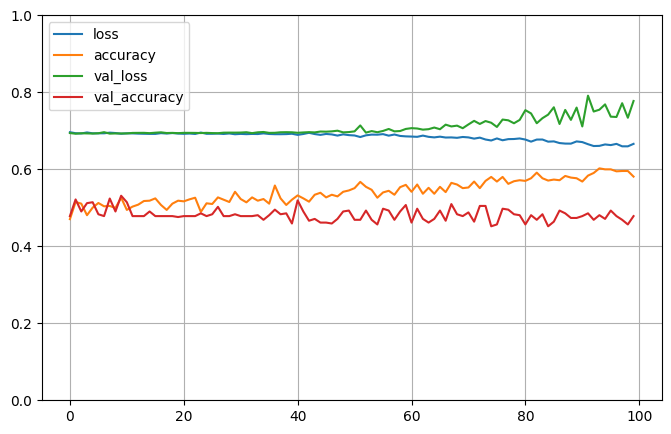

In [100]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [101]:
loss, accuracy = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
#print(f'Loss \t = {loss}')
print(f'Accuracy = {accuracy}')

Accuracy = 0.5144927501678467


13/13 [==============================] - 1s 6ms/step


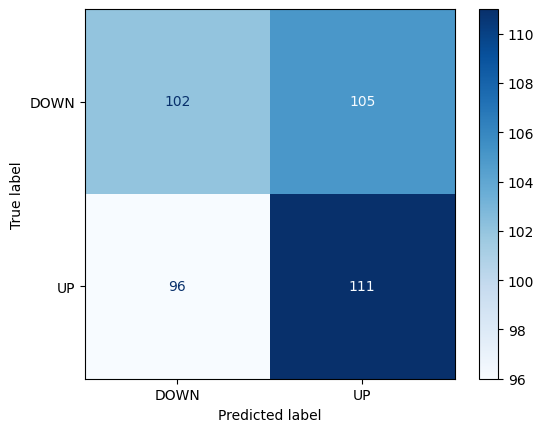

In [102]:
y_pred_probability = model.predict(X_test_reshaped)
y_pred_binary = (y_pred_probability >= 0.5).astype(int)
cm = confusion_matrix(y_test_reshaped.astype(int), y_pred_binary, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DOWN','UP'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

13/13 [==============================] - 0s 6ms/step


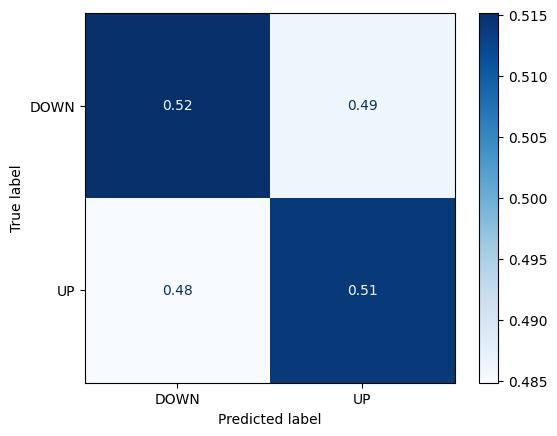

In [103]:
y_pred_probability = model.predict(X_test_reshaped)
y_pred_binary = (y_pred_probability >= 0.5).astype(int)
cm = confusion_matrix(y_test_reshaped.astype(int), y_pred_binary, labels=[0,1], normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DOWN','UP'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

13/13 [==============================] - 0s 5ms/step


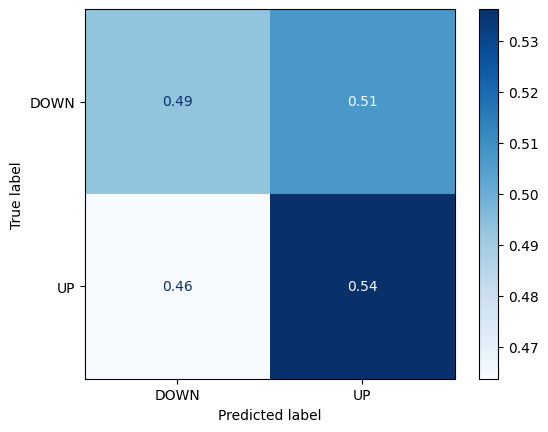

In [104]:
y_pred_probability = model.predict(X_test_reshaped)
y_pred_binary = (y_pred_probability >= 0.5).astype(int)
cm = confusion_matrix(y_test_reshaped.astype(int), y_pred_binary, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DOWN','UP'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

13/13 [==============================] - 0s 5ms/step


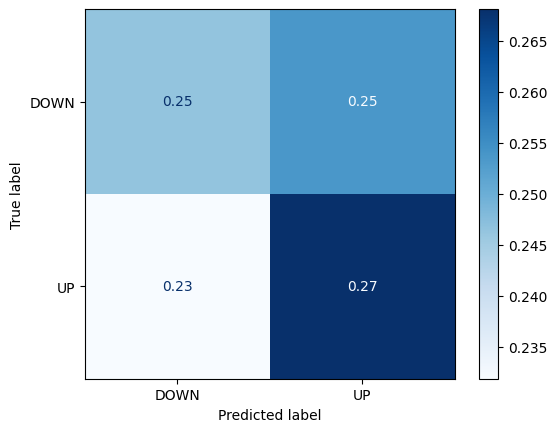

In [105]:
y_pred_probability = model.predict(X_test_reshaped)
y_pred_binary = (y_pred_probability >= 0.5).astype(int)
cm = confusion_matrix(y_test_reshaped.astype(int), y_pred_binary, labels=[0,1], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DOWN','UP'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

## References

A deep learning framework for financial time series using stacked autoencoders and long-short term memory 
https://stackoverflow.com/questions/77582620/tensorflow-pywrap-tf2-importerror-dll-load-failed

## Draft

In [106]:
pd.Series(y_test_reshaped).value_counts()

1.0    207
0.0    207
Name: count, dtype: int64

In [107]:
pd.Series(y_pred_binary.reshape(-1)).value_counts()

1    216
0    198
Name: count, dtype: int64